### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий 

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 1


### Дисциплина: Методы машинного обучения

##### Студент:  Бармина Ольга Константиновна
##### Группа:   НФИбд-01-19

## Москва 2022
***

### Вариант №3

1. Загрузите заданный в индивидуальном задании набор данных из Tensorflow Datasets. 
2. Выполните визуализацию независимой и зависимой переменных в соответствии с индивидуальным заданием, подписывая оси и рисунок. 
3. Постройте парную линейную регрессию при помощи точного подхода и при помощи нейронной сети с одним нейроном. Вычислите и сравните значения показателей качества R^2 двух подходов.
4. Постройте диаграмму рассеяния для независимого и зависимого признаков и изобразите линии двух построенных парных регрессий, подписывая оси и рисунок и создавая легенду.
5. Создайте и адаптируйте нормализующий слой Tensorflow для всех признаков набора данных (за исключением зависимого признака).
6. Используя созданный нормализующий слой, постройте регресоры на базе следующих моделей множественной регрессии: линейной регрессии, гребневой регрессии (L2), лассо регрессии (L1)
7. Определите среди построенных моделей модель множественной регрессии с наиболее высоким качеством по показателю, указанному в индивидуальном задании.
8. Для лучшего регрессора визуализируйте кривые обучения (в зависимости от эпохи обучения).
9. Определите медианные значения признаков (кроме независимого и зависимого признаков) и для построенных медианных значений визуализируйте на плоскости с независимым признаком в качестве оси абсцисс и зависимым признаком в качестве оси ординат точки тестовой выборки и линии (графики) различных моделей множественной регрессии разными цветами. Подпишите оси и создайте легенду и заголовок для рисунка.

С условиями:

1. Набор данных: diamonds 

2. Независимая переменная: features/carat 

3. Зависимая переменная: features/x 

4. Визуализация для независимой переменной – эмпирическая функция распределения 

5. Визуализация для зависимой переменной – диаграмма размаха 

6. Показатель качества регрессии – R^2 (коэффициент детерминации) 

In [1]:
pip install tfds-nightly

In [2]:
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# загрузим датасет и преобразуем его в датафрейм
ds = tfds.load("diamonds", split = 'train')
df = tfds.as_dataframe(ds)
df = pd.DataFrame(df)

df.head()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/53940 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/diamonds/1.0.0.incompleteMGVFUD/diamonds-train.tfrecord*...:   0%|          | …

Dataset diamonds downloaded and prepared to ~/tensorflow_datasets/diamonds/1.0.0. Subsequent calls will reuse this data.


,features/carat,features/clarity,features/color,features/cut,features/depth,features/table,features/x,features/y,features/z,price
0,1.26,2,4,2,60.599998,60.0,6.97,7.00,4.23,6546.0
1,0.80,3,4,4,62.099998,54.0,5.96,5.99,3.71,3030.0
2,0.56,4,2,4,61.700001,54.0,5.28,5.32,3.27,1915.0
3,1.51,3,6,1,64.000000,58.0,7.24,7.27,4.64,6936.0
4,0.33,6,5,4,62.200001,54.0,4.43,4.45,2.76,646.0


In [4]:
# Независимая (x) и зависимая (y) переменные
x = df['features/carat'].to_numpy()
y = df['features/x'].to_numpy()

(53940,)

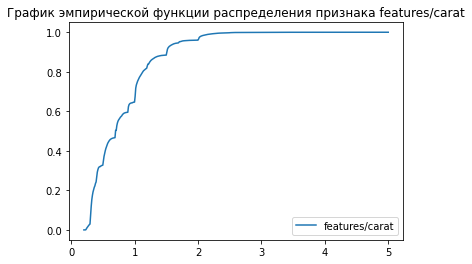

In [5]:
# Выполним визуализацию независимой переменной с помощью эмпирической функции распределения
def ECDF(data, x):
    counter = 0
    for v in data:
        if v <= x:
            counter += 1
    return counter / len(data)

samples = x # sepal length
npoints = 500
dx = (samples.max()-samples.min())/npoints

xlist = [samples.min()+dx*i for i in range(npoints)]
ylist = [ECDF(samples, x) for x in xlist]

df_ECDF = pd.DataFrame(ylist, columns=['features/carat'],index=xlist)

df_ECDF.plot.line(title='График эмпирической функции распределения признака features/carat');

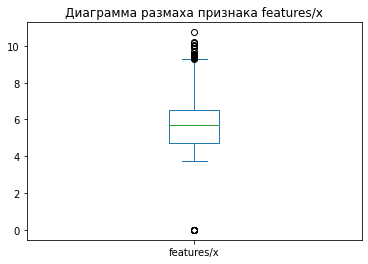

In [6]:
# Выполним визуализацию зависимой переменной с помощью диаграммы размаха
df['features/x'].plot.box(title='Диаграмма размаха признака features/x');

In [7]:
# пропишем класс для расчета линейной регрессии точным подходом
class SimpleLinReg:

    def __init__(self):
        self.a_ = None
        self.b_ = None

    def fit(self, x_train, y_train):
        assert x_train.ndim == 1, \
            "В данных должен быть один признак"
        assert len(x_train) == len(y_train), \
            "Данные должны иметь одинаковый размер"

        x_mean = np.mean(x_train)
        y_mean = np.mean(y_train)

        self.a_ = (x_train - x_mean).dot(y_train - y_mean) / \
                  (x_train - x_mean).dot(x_train - x_mean)
        self.b_ = y_mean - self.a_ * x_mean

        return self

    def predict(self, x_predict):
        assert x_predict.ndim == 1, \
            "В данных должен быть один признак"
        assert self.a_ is not None and self.b_ is not None, \
            "Модель вначале должна быть обучена"

        return np.array([self._predict(x) for x in x_predict])

    def _predict(self, x_single):
        return self.a_ * x_single + self.b_

    def __repr__(self):
        return "SimpleLinearReg()"

In [8]:
# применим данный метод к нашей выборке
reg = SimpleLinReg()
reg.fit(x, y)

SimpleLinearReg()

In [10]:
# расчитаем показатель качества r^2
y_predict = reg.predict(x)

mse_test = np.sum((y_predict - y)**2) / len(y)
r2_calc = 1 - mse_test/np.var(y)
r2_calc

0.9508087596169756

In [11]:
# расчитаем линейную регрессию с помощью нейросети с одним нейроном
# создаем модель
model = tf.keras.Sequential( [ tf.keras.layers.Dense(1, input_shape=(1,)) ] )

In [12]:
# компилируем модель
model.compile(
    loss=tf.keras.losses.mean_absolute_error,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.25),
    metrics=['mean_absolute_error']
)

In [13]:
# обучаем модель в 20 эпох с нашими данными
model.fit(x, y, epochs=20)

Epoch 1/20
1686/1686 [==============================] - 3s 1ms/step - loss: 0.2115 - mean_absolute_error: 0.2115
Epoch 2/20
1686/1686 [==============================] - 2s 1ms/step - loss: 0.1892 - mean_absolute_error: 0.1892
Epoch 3/20
1686/1686 [==============================] - 2s 1ms/step - loss: 0.1868 - mean_absolute_error: 0.1868
Epoch 4/20
1686/1686 [==============================] - 2s 1ms/step - loss: 0.1873 - mean_absolute_error: 0.1873
Epoch 5/20
1686/1686 [==============================] - 2s 1ms/step - loss: 0.1857 - mean_absolute_error: 0.1857
Epoch 6/20
1686/1686 [==============================] - 2s 1ms/step - loss: 0.1877 - mean_absolute_error: 0.1877
Epoch 7/20
1686/1686 [==============================] - 2s 1ms/step - loss: 0.1867 - mean_absolute_error: 0.1867
Epoch 8/20
1686/1686 [==============================] - 2s 1ms/step - loss: 0.1864 - mean_absolute_error: 0.1864
Epoch 9/20
1686/1686 [==============================] - 2s 1ms/step - loss: 0.1873 - mean_absolu

In [14]:
y_predict2 = model.predict(x)
y_predict2

array([[7.0540533],
       [5.8595667],
       [5.2363563],
       ...,
       [4.561212 ],
       [4.7170143],
       [5.5998955]], dtype=float32)

In [15]:
# расчитаем показатель качества R^2
mse_test = np.sum((y_predict2 - y)**2) / len(y)
r2_neuro = 1 - mse_test/np.var(y)
r2_neuro
# видим, что показатель качества нейросети практически в 100000 раз меньше точного подхода

-119520.1736554254

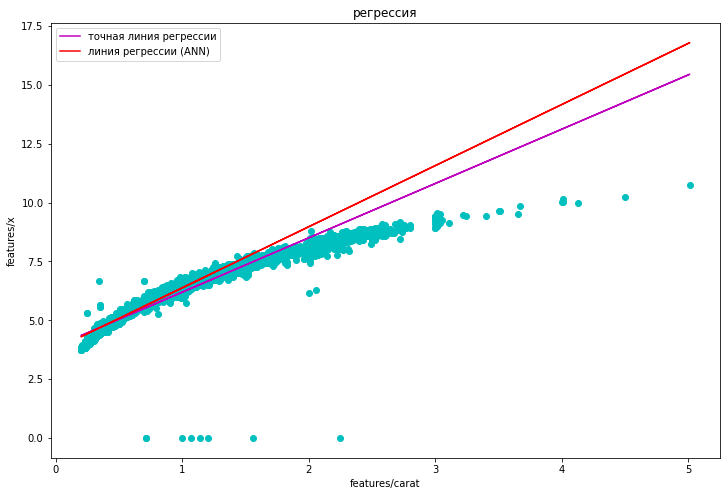

In [16]:
# построим диаграмму рассеяния для признаков и линии регрессий, полученные 2мя способами
plt.figure(figsize=(12,8))
plt.scatter(x, y, c='c')
plt.plot(x, y_predict, c='m', label='точная линия регрессии')
plt.plot(x, y_predict2, c='r', label='линия регрессии (ANN)')
plt.xlabel('features/carat')
plt.ylabel('features/x')
plt.title('регрессия')
plt.legend();

In [17]:
# создаем слой нормализации
normalizer = tf.keras.layers.Normalization()

In [18]:
# адаптируем его к нашим данным (все признаки, кроме зависимого)
normalizer.adapt(df.drop('features/x', axis=1))

In [20]:
# преобразуем данные в массив numpy
normalizer(df.drop('features/x', axis=1)[0:5]).numpy()

array([[ 0.97479874, -0.6380971 ,  0.8264166 , -0.8097021 , -0.80230343,
         1.1380078 ,  1.1080048 ,  0.9795579 ,  0.65503705],
       [ 0.00434631, -0.03097475,  0.8264166 ,  0.98147196,  0.24474058,
        -1.5472023 ,  0.22368513,  0.24269116, -0.22629963],
       [-0.5019767 ,  0.5761476 , -0.3493036 ,  0.98147196, -0.03446956,
        -1.5472023 , -0.36294228, -0.38081157, -0.5057906 ],
       [ 1.5022186 , -0.03097475,  2.002137  , -1.7052891 ,  1.5709974 ,
         0.24293777,  1.344407  ,  1.5605488 ,  0.7527962 ],
       [-0.98720294,  1.7903924 ,  1.4142767 ,  0.98147196,  0.3145451 ,
        -1.5472023 , -1.1246831 , -1.1035078 , -0.82388395]],
      dtype=float32)

In [21]:
# расчитаем парную регрессию по признаку features/carat
feature = np.array(df['features/carat'])

feature_normalizer = tf.keras.layers.Normalization(axis=None,input_shape=(1,)) 
feature_normalizer.adapt(feature)

In [22]:
# строим последовательную модель с двумя слоями
feature_model = tf.keras.Sequential([
    feature_normalizer,
    tf.keras.layers.Dense(units=1)
])

feature_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [23]:
# проверим результат на первых 10ти значениях
print(feature[:10])
feature_model.predict(feature[:10])

[1.26 0.8  0.56 1.51 0.33 0.66 0.78 2.01 0.8  1.65]


array([[-0.736745  ],
       [-0.00328509],
       [ 0.37938964],
       [-1.1353645 ],
       [ 0.7461196 ],
       [ 0.21994182],
       [ 0.02860453],
       [-1.9326036 ],
       [-0.00328509],
       [-1.3585914 ]], dtype=float32)

In [24]:
# настроим процедуру обучения
feature_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.25),
    loss='mean_absolute_error')

In [25]:
# выполним само обучение
history = feature_model.fit(
    x, y,
    epochs=100,
    # подавляем вывод
    verbose=0,
    # проверка (валидация) на 20% обучающих данных
    validation_split = 0.2)

In [26]:
# визуализируем ход обучения модели
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.187713,0.181871,95
96,0.189269,0.186792,96
97,0.189343,0.200136,97
98,0.187248,0.181424,98
99,0.191321,0.181144,99


In [27]:
# создадим шаблон диаграммы для отображения потерь
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, max(history.history['loss'])*2])
  plt.xlabel('Эпохи обучения')
  plt.ylabel('Ошибка')
  plt.legend()
  plt.grid(True)

In [28]:
# проведем резуляризацию L1 и L2 аналогичным образом
df_normalizer = tf.keras.layers.Normalization()
df_normalizer.adapt(df)

In [29]:
l1_model = tf.keras.Sequential([
    df_normalizer,
    tf.keras.layers.Dense(units=1, 
                          kernel_regularizer=tf.keras.regularizers.L1(l1=0.01))
])

In [30]:
l1_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.25),
    loss='mean_absolute_error')

In [31]:
history_l1 = l1_model.fit(
    df, y, 
    epochs=100,
    # подавляем вывод
    verbose=0,
    # проверка (валидация) на 20% обучающих данных
    validation_split = 0.2)

In [32]:
l2_model = tf.keras.Sequential([
    df_normalizer,
    tf.keras.layers.Dense(units=1, 
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))
])

In [33]:
l2_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.25),
    loss='mean_absolute_error')

In [34]:
history_l2 = l2_model.fit(
    df, y, 
    epochs=100,
    # подавляем вывод
    verbose=0,
    # проверка (валидация) на 20% обучающих данных
    validation_split = 0.2)

In [35]:
# расчитаем показатель качества r^2 для каждого регресора
mse_test = np.sum((np.array(history.history['loss']) - np.array(history.history['val_loss'])**2)) / len(history.history['val_loss'])
err_calc = 1 - mse_test/np.var(history.history['val_loss'])

mse_test = np.sum((np.array(history_l1.history['loss']) - np.array(history_l1.history['val_loss'])**2)) / len(history_l1.history['val_loss'])
err_l1 = 1 - mse_test/np.var(history_l1.history['val_loss'])

mse_test = np.sum((np.array(history_l2.history['loss']) - np.array(history_l2.history['val_loss'])**2)) / len(history_l2.history['val_loss'])
err_l2 = 1 - mse_test/np.var(history_l2.history['val_loss'])

In [36]:
print(err_calc, err_l1, err_l2)
# заметим, что натбольшее качество у L2 регрессии

-529.6697504484058 -42.08834527612802 -55.15110611136031


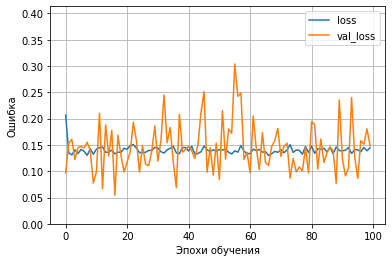

In [37]:
# построим диаграмму кривых обучения
l2_model.layers[1].kernel
plot_loss(history_l2)

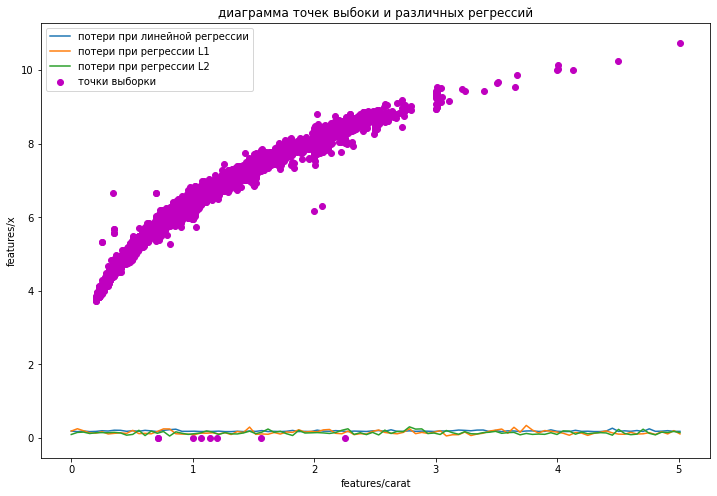

In [53]:
# создадим диаграмму по условиям пункта №9
plt.figure(figsize=(12,8))
plt.scatter(x, y, c='m', label='точки выборки')
plt.plot(np.linspace(0,np.max(x),100), history.history['val_loss'], label='потери при линейной регрессии')
plt.plot(np.linspace(0,np.max(x),100), history_l1.history['val_loss'], label='потери при регрессии L1')
plt.plot(np.linspace(0,np.max(x),100), history_l2.history['val_loss'], label='потери при регрессии L2')
plt.xlabel('features/carat')
plt.ylabel('features/x')
plt.title('диаграмма точек выбоки и различных регрессий')
plt.legend();